# Amazon Fine Food Reviews Analysis


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.


#### In this assignment I perform the following steps,

1.  Data reading
2.  Exploratory Data Analysis
3.  Text Preprocessing on Review text data and Summary data
4.  Time based sorting of data and sample the data from the dataset

Next I do 2 featurizations AvgW2V and TFIDF-W2V for Agglomerative and DBSCAN Clustering. Below steps are performed:-

##### Agglomerative Clustering 

1. Featurizations - AvgW2V , TFIDF-W2V
2. Agglomerative Clustering on  Avg W2V with Clusters 2, 5, 7
3. Agglomerative Clustering on  TFIDF-W2V with Clusters 2, 5, 8.
4. Find Number of words in each cluster
5. Word Clouds for Cluster

##### DBSCAN Clustering

1. Featurizations - AvgW2V , TFIDF-W2V
2. Standardising the vector data
3. Finding min_points
4. Computing distances of nth-nearest neighbours to min_points
5. Plotting Distances vs Points plot
6. Finding Number of Noise points which are labeled as -1
7. Removing noise points and printing number of remaining points
8. Number of Clusters
9. Number of Words in Cluster
10. Word Clouds for Cluster

# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


In [4]:

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [5]:
# Loading the data
# using SQLite Table to read data.
con = sqlite3.connect('I:\Python\database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(5)

Number of data points in our data (525814, 10)


Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      1  1303862400   
1                     0                       0      0  1346976000   
2                     1                       1      1  1219017600   
3                     3                       3      0  1307923200   
4                     0                       0      1  1350777600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitality canned d...  
1      Not as Advertised  Product arrived labeled as Jumbo Salted Peanut...  
2  "Delight" says it all  This is a confection that has been around a fe...  
3         Cough Medicine  If you are looking for the secret ingredient i...  
4            Great taffy  Great taffy at a great price.  There was a wid...

## [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is necessary to remove duplicates in order to get unbiased results for the analysis of the data. Hence in order to reduce redundancy it's better to eliminate the rows that have same parameters.

The method used to perform deduplication is that, we first sort the data according to ProductId and then just keep the first similar product review and delete the others. This method ensures that there is only one representative for each product.

In [6]:
#Sorting data according to ProductId in ascending order
sorted_data = filtered_data.sort_values('ProductId', axis = 0, ascending = True, inplace = False, kind = 'quicksort', na_position = 'last')

#Dropping duplicates. It says that find duplicates with {'UserId', 'ProfileName', 'Time', 'Text'} values same. Then it is a duplicate
# By using drop_duplicate function we just keep the first product Id of the duplicates and remove the remaining.
final_data = sorted_data.drop_duplicates(subset = {'UserId', 'ProfileName', 'Time', 'Text'}, keep = 'first', inplace = False)

# Now it prints total reviews after removing duplicates.
print('Total number of reviews in the dataframe after removing duplicated:', final_data.shape)


Total number of reviews in the dataframe after removing duplicated: (364173, 10)


In [7]:
# HelpfulnessNumerator should always be less than HelpfulnessDenominator. 
# So check if any reviews have HelpfulnessNumerator greater than HelpfulnessDenominator and remove them

final_data = final_data[final_data.HelpfulnessNumerator <= final_data.HelpfulnessDenominator]
final_data.shape

(364171, 10)

In [8]:
#Checking to see how much % of data still remains
(final_data['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25852107399194

In [9]:
# Lets see how many total reviews left
print(final_data.shape)

#How many positive and negative reviews are present in the dataset?
final_data['Score'].value_counts()


(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

#### Observation:-

From the above output we can see that there are many positive reviews and fewer negative reviews.


#  [3] Text Preprocessing

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis.

1. By removing stop-words, BoW vector will be small and more meaningful
2. Lemmatization is a process of breaking a sentence into words. It is language and context dependent

Hence in the Preprocessing phase we do the following in the order below:-

1. Remove all URL's
2. Remove all tags from the strings
3. Expanding English language contractions like, you've -> you have
4. Remove any punctuations or limited set of special characters like , or . or # etc.
5. Check if the word is made up of english letters and is not alpha-numeric
6. Remove words with numbers
7. Remove spacial characters
8. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
9. Convert the words to lowercase
10. Remove Stopwords
11. Finally Stemming the words which are related, to their stem form/root/base form (Snowball stemmer is used as it is obsereved to be better than Porter Stemming)

After which we collect the words used to describe positive and negative reviews

## [3.1]. Preprocessing Review Text

In [10]:
# printing some random reviews
sent_5 = final_data['Text'].values[5]
print(sent_5)
print("="*50)

sent_60000 = final_data['Text'].values[60000]
print(sent_60000)
print("="*50)

sent_15500 = final_data['Text'].values[15500]
print(sent_15500)
print("="*50)

sent_4900 = final_data['Text'].values[4900]
print(sent_4900)
print("="*50)

A charming, rhyming book that describes the circumstances under which you eat (or don't) chicken soup with rice, month-by-month. This sounds like the kind of thing kids would make up while they're out of recess and sing over and over until they drive the teachers crazy. It's cute and catchy and sounds really childlike but is skillfully written.
<a href="http://www.amazon.com/gp/product/B000F4D5WG">Edward & Sons Organic Croutons, Italian Herbs, 5.25-Ounce Packs (Pack of 6)</a><br /><br />Knowing that I have to watch my calories I have been eating nothing but low cal foods for quite a while.  Part of my diet consists of big salads and low fat Progresso soups. I wanted something extra that I could add to a salad  and/or a soup.  I decided to try these.  They are extremely salty and aside from that have no other taste.  I would not re order these again.  I do admit that I do not care for salty foods but if salt is used the taste of it should not be so overwhelming. Some foods are understan

In [11]:
# Remove urls from text ----  https://stackoverflow.com/a/40823105/4084039
import re
sent_5 = re.sub(r"http\S+", "", sent_5)
sent_60000 = re.sub(r"http\S+", "", sent_60000)
sent_15500 = re.sub(r"http\S+", "", sent_15500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_60000)

<a href=" & Sons Organic Croutons, Italian Herbs, 5.25-Ounce Packs (Pack of 6)</a><br /><br />Knowing that I have to watch my calories I have been eating nothing but low cal foods for quite a while.  Part of my diet consists of big salads and low fat Progresso soups. I wanted something extra that I could add to a salad  and/or a soup.  I decided to try these.  They are extremely salty and aside from that have no other taste.  I would not re order these again.  I do admit that I do not care for salty foods but if salt is used the taste of it should not be so overwhelming. Some foods are understandably noted for being salty, anchovies, pretzels etc. I do eat pretzels and like them as long as I don't feel as if I put several tablespoons of salt in my mouth. I do not taste any of the herbs that I expected in a product which claims to have as one of it's ingredients Italian herbs.


In [12]:
# Removes all tags from a string --- https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element

from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_5, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_15500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

A charming, rhyming book that describes the circumstances under which you eat (or don't) chicken soup with rice, month-by-month. This sounds like the kind of thing kids would make up while they're out of recess and sing over and over until they drive the teachers crazy. It's cute and catchy and sounds really childlike but is skillfully written.
I use this exclusively in all my cooking...I don't understand why the price went up so drastically...I have many of the ladies I work with that are hooked on this product and they want me to get them more
Can't do sugar.  Have tried scores of SF Syrups.  NONE of them can touch the excellence of this product.Thick, delicious.  Perfect.  3 ingredients: Water, Maltitol, Natural Maple Flavor.  PERIOD.  No chemicals.  No garbage.Have numerous friends & family members hooked on this stuff.  My husband & son, who do NOT like "sugar free" prefer this over major label regular syrup.I use this as my SWEETENER in baking: cheesecakes, white brownies, muffin

In [13]:
# Expanding English language contractions  like, you've -> you have,  aren't -> are not
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [14]:
sent_5 = decontracted(sent_5)
print(sent_5)
print("="*50)

A charming, rhyming book that describes the circumstances under which you eat (or do not) chicken soup with rice, month-by-month. This sounds like the kind of thing kids would make up while they are out of recess and sing over and over until they drive the teachers crazy. It is cute and catchy and sounds really childlike but is skillfully written.


In [15]:
# Removes punctuations from strings ---  https://stackoverflow.com/questions/265960/best-way-to-strip-punctuation-from-a-string-in-python
sent_5 = re.sub(r"http\S+", "", sent_5)
sent_60000 = re.sub(r'[^\w\s]','', sent_60000)
sent_15500 = re.sub(r'[^\w\s]','', sent_15500)
sent_4900 = re.sub(r'[^\w\s]','', sent_4900)

print(sent_60000)

a href  Sons Organic Croutons Italian Herbs 525Ounce Packs Pack of 6abr br Knowing that I have to watch my calories I have been eating nothing but low cal foods for quite a while  Part of my diet consists of big salads and low fat Progresso soups I wanted something extra that I could add to a salad  andor a soup  I decided to try these  They are extremely salty and aside from that have no other taste  I would not re order these again  I do admit that I do not care for salty foods but if salt is used the taste of it should not be so overwhelming Some foods are understandably noted for being salty anchovies pretzels etc I do eat pretzels and like them as long as I dont feel as if I put several tablespoons of salt in my mouth I do not taste any of the herbs that I expected in a product which claims to have as one of its ingredients Italian herbs


In [16]:
#remove words with numbers --- https://stackoverflow.com/a/18082370/4084039
sent_60000 = re.sub("\S*\d\S*", "", sent_60000).strip()
print(sent_60000)

a href  Sons Organic Croutons Italian Herbs  Packs Pack of  br Knowing that I have to watch my calories I have been eating nothing but low cal foods for quite a while  Part of my diet consists of big salads and low fat Progresso soups I wanted something extra that I could add to a salad  andor a soup  I decided to try these  They are extremely salty and aside from that have no other taste  I would not re order these again  I do admit that I do not care for salty foods but if salt is used the taste of it should not be so overwhelming Some foods are understandably noted for being salty anchovies pretzels etc I do eat pretzels and like them as long as I dont feel as if I put several tablespoons of salt in my mouth I do not taste any of the herbs that I expected in a product which claims to have as one of its ingredients Italian herbs


In [17]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_4900 = re.sub('[^A-Za-z0-9]+', ' ', sent_4900)
print(sent_4900)

Cant do sugar Have tried scores of SF Syrups NONE of them can touch the excellence of this productbr br Thick delicious Perfect 3 ingredients Water Maltitol Natural Maple Flavor PERIOD No chemicals No garbagebr br Have numerous friends family members hooked on this stuff My husband son who do NOT like sugar free prefer this over major label regular syrupbr br I use this as my SWEETENER in baking cheesecakes white brownies muffins pumpkin pies etc Unbelievably deliciousbr br Can you tell I like it 


In [18]:
# Converting words into lowercase
sent_4900 = sent_4900.lower()
print(sent_4900)

cant do sugar have tried scores of sf syrups none of them can touch the excellence of this productbr br thick delicious perfect 3 ingredients water maltitol natural maple flavor period no chemicals no garbagebr br have numerous friends family members hooked on this stuff my husband son who do not like sugar free prefer this over major label regular syrupbr br i use this as my sweetener in baking cheesecakes white brownies muffins pumpkin pies etc unbelievably deliciousbr br can you tell i like it 


In [19]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [20]:
# Combining all the above stundents 
from tqdm import tqdm
final_strings = []
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
# tqdm is for printing the status bar
for sentence in tqdm(final_data['Text'].values):
    sentence = re.sub(r"http\S+", "", sentence)  # To remove urls from text
    sentence = BeautifulSoup(sentence, 'lxml').get_text() # To remove all tags from an element
    sentence = decontracted(sentence) # Expanding English language contractions  like, you've -> you have,  aren't -> are not
    sentence = re.sub(r'[^\w\s]','', sentence)
    sentence = re.sub("\S*\d\S*", "", sentence).strip() # removes words with numbers
    sentence = re.sub('[^A-Za-z]+', ' ', sentence) # removes special characters
    sentence = sentence.lower()  # Converting words into lowercase
    # https://gist.github.com/sebleier/554280
    sentence = ' '.join(e.lower() for e in sentence.split() if e.lower() not in stopwords)
    final_strings.append(sentence.strip())

100%|██████████| 364171/364171 [03:29<00:00, 1735.47it/s]


In [21]:
final_strings[55000]

'great product anyone would love even not gluten free great servicefast'

In [22]:
# store final_data table into an SQlLite table for future.
conn = sqlite3.connect('final_data.sqlite')
c=conn.cursor()
conn.text_factory = str
final_data.to_sql('Reviews', conn,  schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)


In [23]:
final_data['CleanedText'] = final_strings
final_data.shape
final_data.head(3)


Id   ProductId          UserId            ProfileName  \
138706  150524  0006641040   ACITT7DI6IDDL        shari zychinski   
138688  150506  0006641040  A2IW4PEEKO2R0U                  Tracy   
138689  150507  0006641040  A1S4A3IQ2MU7V4  sally sue "sally sue"   

        HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
138706                     0                       0      1   939340800   
138688                     1                       1      1  1194739200   
138689                     1                       1      1  1191456000   

                                           Summary  \
138706                   EVERY book is educational   
138688  Love the book, miss the hard cover version   
138689               chicken soup with rice months   

                                                     Text  \
138706  this witty little book makes my son laugh at l...   
138688  I grew up reading these Sendak books, and watc...   
138689  This is a fun way for children to learn their ...   

                                              CleanedText  
138706  witty little book makes son laugh loud recite ...  
138688  grew reading sendak books watching really rosi...  
138689  fun way children learn months year learn poems...

In [24]:
print(final_data['Score'].value_counts())

1    307061
0     57110
Name: Score, dtype: int64


## [3.2] Preprocessing Reviews Summary

In [25]:
# printing some random reviews
sent_6 = final_data['Text'].values[6]
print(sent_6)
print("="*50)

sent_5000 = final_data['Text'].values[5000]
print(sent_5000)
print("="*50)

sent_50000 = final_data['Text'].values[50000]
print(sent_50000)
print("="*50)

sent_355000 = final_data['Text'].values[355000]
print(sent_355000)
print("="*50)

I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.
late delivered, I paid extra charge for faster delivery but is not delivered on the time i've expected it.
We use marinade on a weekly basis, and this is another flavor from Lawry's that is really good.  Not too spicy or overwhelming, making it a good marinade for everyone (even picky kids who don't like spicy tastes).
Great taste and amazing crunch. If you have never experienced the large/deluxe/fancy peanuts and have only had 

In [26]:
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_6, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_5000, 'lxml')
text= soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_50000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_355000, 'lxml')
text = soup.get_text()
print(text)

I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.First, this book taught him the months of the year.Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.
late delivered, I paid extra charge for faster delivery but is not delivered on the time i've expected it.
We use marinade on a weekly basis, and this is another flavor from Lawry's that is really good.  Not too spicy or overwhelming, making it a good marinade for everyone (even picky kids who don't like spicy tastes).
Great taste and amazing crunch. If you have never experienced the large/deluxe/fancy peanuts and have only had Planters or regular "salted in the s

In [27]:
# Expanding English language contractions  like, you've -> you have,  aren't -> are not
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [28]:
sent_5000 = decontracted(sent_5000)
print(sent_5000)
print("="*50)

late delivered, I paid extra charge for faster delivery but is not delivered on the time i have expected it.


In [29]:
#remove words with numbers ---- https://stackoverflow.com/a/18082370/4084039
sent_6 = re.sub("\S*\d\S*", "", sent_6).strip()
print(sent_6)

I set aside at least an hour each day to read to my son  y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to  y/o old to  /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [30]:
#remove spacial character ----- https://stackoverflow.com/a/5843547/4084039
sent_355000 = re.sub('[^A-Za-z0-9]+', ' ', sent_355000)
print(sent_355000)

Great taste and amazing crunch If you have never experienced the large deluxe fancy peanuts and have only had Planters or regular salted in the shell you are in for a wonderful experience The intense taste and solid crunch will keep your hand in the can til they are gone 


In [31]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [32]:
# Performing all the preprocessing steps on Summary data.
import warnings
warnings.filterwarnings('ignore')  # "error", "ignore", "always", "default", "module" or "once"
from tqdm import tqdm
summary_data = []
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
# tqdm is for printing the status bar
for sentence in tqdm(final_data['Summary'].values):
    sentence = re.sub(r"http\S+", "", sentence)  # To remove urls from text
    sentence = BeautifulSoup(sentence, 'lxml').get_text() # To remove all tags from an element
    sentence = decontracted(sentence) # Expanding English language contractions  like, you've -> you have,  aren't -> are not
    sentence = re.sub(r'[^\w\s]','', sentence)
    sentence = re.sub("\S*\d\S*", "", sentence).strip() # removes words with numbers
    sentence = re.sub('[^A-Za-z]+', ' ', sentence) # removes special characters
    sentence = sentence.lower()  # Converting words into lowercase
    # https://gist.github.com/sebleier/554280
    sentence = ' '.join(e.lower() for e in sentence.split() if e.lower() not in stopwords)
    summary_data.append(sentence.strip())

100%|██████████| 364171/364171 [02:17<00:00, 2646.67it/s]


In [33]:
summary_data[56000]

'awesome yummy'

In [34]:
# store final_data table into an SQlLite table for future.
conn = sqlite3.connect('final_data.sqlite')
c=conn.cursor()
conn.text_factory = str
final_data.to_sql('Reviews', conn,  schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)


In [35]:
final_data['CleanedSummary'] = summary_data 
final_data.shape
final_data.head(3)

Id   ProductId          UserId            ProfileName  \
138706  150524  0006641040   ACITT7DI6IDDL        shari zychinski   
138688  150506  0006641040  A2IW4PEEKO2R0U                  Tracy   
138689  150507  0006641040  A1S4A3IQ2MU7V4  sally sue "sally sue"   

        HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
138706                     0                       0      1   939340800   
138688                     1                       1      1  1194739200   
138689                     1                       1      1  1191456000   

                                           Summary  \
138706                   EVERY book is educational   
138688  Love the book, miss the hard cover version   
138689               chicken soup with rice months   

                                                     Text  \
138706  this witty little book makes my son laugh at l...   
138688  I grew up reading these Sendak books, and watc...   
138689  This is a fun way for children to learn their ...   

                                              CleanedText  \
138706  witty little book makes son laugh loud recite ...   
138688  grew reading sendak books watching really rosi...   
138689  fun way children learn months year learn poems...   

                           CleanedSummary  
138706             every book educational  
138688  love book miss hard cover version  
138689           chicken soup rice months

In [36]:
print(final_data['Score'].value_counts())

1    307061
0     57110
Name: Score, dtype: int64


## 4. Sample the data from the Dataset

### [4.1] Time Based Sorting


In [37]:
# sorting data using time
final_data['Time'] = pd.to_datetime(final_data['Time'])
final_data = final_data.sort_values(by = 'Time', ascending = True)


In [38]:
# display top 5 rows
final_data.head(5)

Id   ProductId          UserId               ProfileName  \
138706  150524  0006641040   ACITT7DI6IDDL           shari zychinski   
138683  150501  0006641040   AJ46FKXOVC7NR        Nicholas A Mesiano   
417839  451856  B00004CXX9   AIUWLEQ1ADEG5          Elizabeth Medina   
346055  374359  B00004CI84  A344SMIA5JECGM           Vincent P. Ross   
417838  451855  B00004CXX9   AJH6LUC1UT1ON  The Phantom of the Opera   

        HelpfulnessNumerator  HelpfulnessDenominator  Score  \
138706                     0                       0      1   
138683                     2                       2      1   
417839                     0                       0      1   
346055                     1                       2      1   
417838                     0                       0      1   

                                Time  \
138706 1970-01-01 00:00:00.939340800   
138683 1970-01-01 00:00:00.940809600   
417839 1970-01-01 00:00:00.944092800   
346055 1970-01-01 00:00:00.944438400   
417838 1970-01-01 00:00:00.946857600   

                                                  Summary  \
138706                          EVERY book is educational   
138683  This whole series is great way to spend time w...   
417839                               Entertainingl Funny!   
346055                            A modern day fairy tale   
417838                                         FANTASTIC!   

                                                     Text  \
138706  this witty little book makes my son laugh at l...   
138683  I can remember seeing the show when it aired o...   
417839  Beetlejuice is a well written movie ..... ever...   
346055  A twist of rumplestiskin captured on film, sta...   
417838  Beetlejuice is an excellent and funny movie. K...   

                                              CleanedText  \
138706  witty little book makes son laugh loud recite ...   
138683  remember seeing show aired television years ag...   
417839  beetlejuice well written movie everything exce...   
346055  twist rumplestiskin captured film starring mic...   
417838  beetlejuice excellent funny movie keaton hilar...   

                                 CleanedSummary  
138706                   every book educational  
138683  whole series great way spend time child  
417839                      entertainingl funny  
346055                    modern day fairy tale  
417838                                fantastic

### 4.2 Sample the data from the Dataset

In [39]:
# taking sample 5000 data points
sample_data = final_data.iloc[:5000,:]
print(sample_data.shape)
print(sample_data['Score'].value_counts())

(5000, 12)
1    4423
0     577
Name: Score, dtype: int64


In [40]:
X1 = sample_data['CleanedText']


In [41]:
# getting words from reviews in X1
words_list = []
for i in X1:
    sent = []
    for word in i.split():
        sent.append(word)
    words_list.append(sent)

# Agglomerative Clustering 

### Hierarchical clustering:-
1. It is also one of the popular clustering method. There are 2 types of Hierarchical clustering.
    1. Agglomerative hierarchical clustering. It is more popular.
    2. Divisive hierarchical clustering
    
##### Agglomerative clustering:- 
It assumes each point as a cluster and takes 2 clusters that are close and combines/group them into one cluster based on some similarity or distance between the clusters. And it continues combining the clusters that are close and at the end we get single large cluster.

We can find the similarity or proximity and inter cluster distance by methods like MIN, MAX, Group Average etc.

##### Divisive clustering:-
1. It is opposite to Agglomerative clustering. It starts with one single big cluster with all points. And at each iteration it divides/breaks the big cluster into many smaller clusters and at the last iteration we get each point as a individual cluster.

2. We can also draw a tree with a hierarchical structure which records the sequence of merges in case of Agglomerative clustering and splits in case of divisive clustering. Such tree is called Dendogram.

3. In case of Agglomerative and divisive clustering we don't give the number of clusters as a hyperparameter like in k-means and we can go deep into the hierarchy till we find the desired splits or merges.

4. When we want to compute similarity between the clusters, we have to compute similarity (MIN, MAX, AVG) between the pairs of  points of each cluster. 

5. We can use kernel trick for these similarities in case of MIN and MAX and Group average/ or these can be trivially kernalized as they just need similarity values, but for Distance between centroids, kernel trick doesn't work as we use the centroids in this case and its difficult to compute similarity between centroids

6. As MIN calculates minimum distance between the points of 2 clusters, it is sensitive to noise and outliers and doesn't work well in case of noise points. It keeps merging noise points into the cluster by computing minimum distance between the points.

7. MAX method is less susceptible to noise and outliers. But by applying MAX method, it tends to break large clustersand MAX is also biased towards/ or higher tendency to create globular clusters or globe like clusters.

8. MIN is also called as Single link agglomerative clustering algorithm and MAX is also referred to as Complete link algorithm.

9. Group Average method strength is, it is less susceptible to noise and outliers and biased towards globular clusters. Its a compromise between MIN and MAX approach.

10. Agglomerative clustering is not very useful when n is large

##### Ward's method:-
1. It is similar to Group Average but the only difference is, the distances between points are squared.

###### Limitations of hierarchical clustering:-
1. There is no mathematical objective function that we can directly solve. It is a good algorithmic solution.
2. MIN, MAX , Group Avg have their own limitations.
3. The most important limitation is time and space complexity and it can't be used when n is large.In this cases we have to use K-means when n is large.

## 5. Featurizations

## 5.1 Word2Vec

In [43]:
# This splits sentences in X1 to list of words.
i=0
list_of_sent_agg=[]
for sent in X1:
    list_of_sent_agg.append(sent.split())

In [44]:
# One sentence is converted into a list
print(X1.values[1])
print("*****************************************************************")
print(list_of_sent_agg[1])

remember seeing show aired television years ago child sister later bought lp day thirty somethingi used series books songs student teaching preschoolers turned whole school purchasing cd along books children tradition lives
*****************************************************************
['remember', 'seeing', 'show', 'aired', 'television', 'years', 'ago', 'child', 'sister', 'later', 'bought', 'lp', 'day', 'thirty', 'somethingi', 'used', 'series', 'books', 'songs', 'student', 'teaching', 'preschoolers', 'turned', 'whole', 'school', 'purchasing', 'cd', 'along', 'books', 'children', 'tradition', 'lives']


In [45]:
from gensim.models import Word2Vec
w2v_model = Word2Vec(list_of_sent_agg, min_count=5, size=50, workers=4)

#words = w2v_model[w2v_model.wv.vocab]
# we can get dictionary of all the words that we have
# we are storing Word2Vec model in w2v_model
words_agg = list(w2v_model.wv.vocab)
print(len(words_agg))

# prints 50 words
print("sample words ", words_agg[0:50])

4976
sample words  ['little', 'book', 'makes', 'son', 'laugh', 'loud', 'car', 'driving', 'along', 'always', 'sing', 'learned', 'india', 'roses', 'love', 'new', 'words', 'classic', 'willing', 'bet', 'still', 'able', 'memory', 'college', 'remember', 'seeing', 'show', 'television', 'years', 'ago', 'child', 'sister', 'later', 'bought', 'day', 'thirty', 'used', 'series', 'books', 'songs', 'student', 'turned', 'whole', 'school', 'purchasing', 'cd', 'children', 'tradition', 'lives', 'beetlejuice']


## 5.2 AVG-W2V

In [46]:
# average Word2Vec for Train data
# compute average word2vec for each review.
from tqdm import tqdm
#List to store all the avg w2vec's 
sent_vectors_agg = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent_agg): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # to count num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in words_agg:
            vec = w2v_model.wv[word] # vector of each word using w2v model
            sent_vec += vec # Adding the vectors
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words  # Taking average of vectors sum of the particular review
    sent_vectors_agg.append(sent_vec)  # Storing the avg w2vec's for each review in the list
print(len(sent_vectors_agg))
print(len(sent_vectors_agg[0]))

100%|██████████| 5000/5000 [00:11<00:00, 439.41it/s]


5000
50


## 5.3 Agglomerative Clustering on Avg W2V with 2 Clusters

In [50]:
from sklearn.cluster import AgglomerativeClustering
Agg_clust = AgglomerativeClustering(n_clusters=2)
Agg_clust.fit(sent_vectors_agg)
Agg_clust

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=2,
            pooling_func=<function mean at 0x000000C2D65D66A8>)

In [51]:
Agg_clust.labels_.shape[0]

5000

### 5.4 Number of words in each cluster

In [60]:
words_data = words_list
Clust1 = []
Clust2 = []

for i in range(Agg_clust.labels_.shape[0]):
    if Agg_clust.labels_[i] == 0:
        Clust1.append(words_data[i])
    else:
        Clust2.append(words_data[i])
                
print("Number of words in Cluster 1 : ",len(Clust1))
print("Number of words in Cluster 2 : ",len(Clust2))


Number of words in Cluster 1 :  2071
Number of words in Cluster 2 :  2929


### 5.5 Word Cloud for Cluster 1

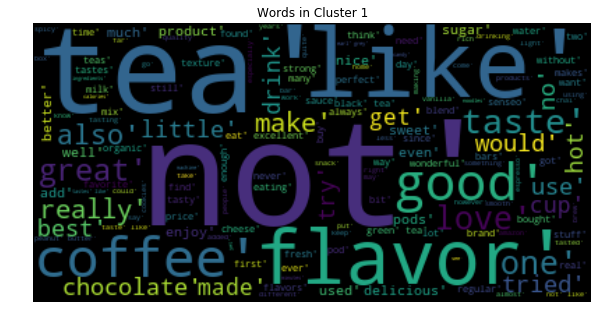

In [67]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd 

stopwords_t = set(STOPWORDS)
wordcloud = WordCloud(background_color="black", max_words=len(str(Clust1)), stopwords=stopwords_t) # , max_font_size=50
wordcloud.generate(str(Clust1))

plt.figure(figsize=(10,10))
plt.title("Words in Cluster 1")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Observation:- 

This word cloud has information about tea and coffee, how it is made, its flavor and taste. It also has information about chocolate and quantity.

### 5.6 Word Cloud for Cluster 2

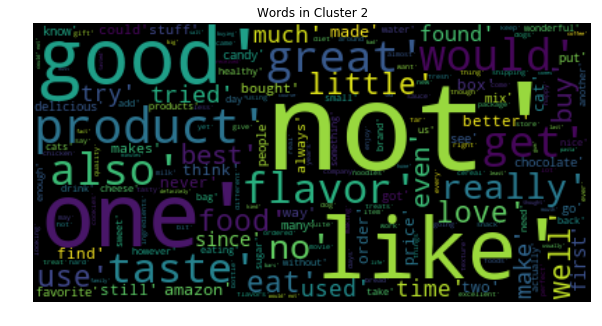

In [68]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd 

stopwords_t = set(STOPWORDS)
wordcloud = WordCloud(background_color="black", max_words=len(str(Clust2)), stopwords=stopwords_t) # , max_font_size=50
wordcloud.generate(str(Clust2))

plt.figure(figsize=(10,10))
plt.title("Words in Cluster 2")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Observation:- 

Word cloud has inforation about a product whether it is good or not. It also says about an eatable and its flavor and taste.

## 5.7 Agglomerative Clustering on Avg-W2V with 5 Clusters

In [47]:
from sklearn.cluster import AgglomerativeClustering

Agg_clust5 = AgglomerativeClustering(n_clusters=5)
Agg_clust5.fit(sent_vectors_agg)
Agg_clust5

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=5,
            pooling_func=<function mean at 0x0000004633E8F400>)

In [48]:
Agg_clust5.labels_.shape[0]

5000

### 5.8  Number of words in each cluster

In [49]:
words_data = words_list
Clust1 = []
Clust2 = []
Clust3 = []
Clust4 = []
Clust5 = []

for i in range(Agg_clust5.labels_.shape[0]):
    if Agg_clust5.labels_[i] == 0:
        Clust1.append(words_data[i])
    elif Agg_clust5.labels_[i] == 1:
        Clust2.append(words_data[i]) 
    elif Agg_clust5.labels_[i] == 2:
        Clust3.append(words_data[i]) 
    elif Agg_clust5.labels_[i] == 3:
        Clust4.append(words_data[i]) 
    else:
        Clust5.append(words_data[i])
                
print("Number of words in Cluster 1 : ",len(Clust1))
print("Number of words in Cluster 2 : ",len(Clust2))
print("Number of words in Cluster 3 : ",len(Clust3))
print("Number of words in Cluster 4 : ",len(Clust4))
print("Number of words in Cluster 5 : ",len(Clust5))

Number of words in Cluster 1 :  873
Number of words in Cluster 2 :  724
Number of words in Cluster 3 :  905
Number of words in Cluster 4 :  1196
Number of words in Cluster 5 :  1302


### 5.9 Word Cloud for Cluster 1

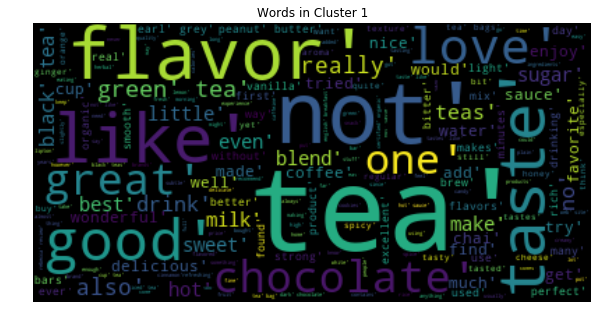

In [50]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd 

stopwords_t = set(STOPWORDS)
wordcloud = WordCloud(background_color="black", max_words=len(str(Clust1)), stopwords=stopwords_t) # , max_font_size=50
wordcloud.generate(str(Clust1))

plt.figure(figsize=(10,10))
plt.title("Words in Cluster 1")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Observation:- 

This word cloud has information about tea and it's different flavors, types and how it taste.

### 5.10 Word Cloud for Cluster 2

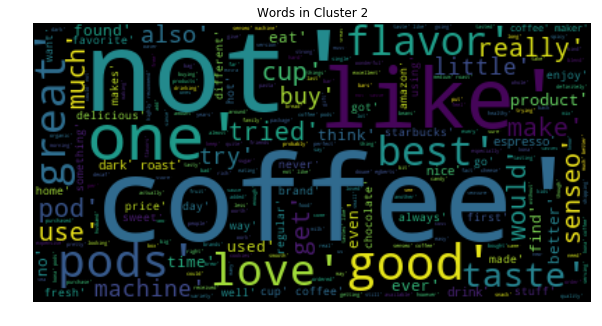

In [51]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd 

stopwords_t = set(STOPWORDS)
wordcloud = WordCloud(background_color="black", max_words=len(str(Clust2)), stopwords=stopwords_t) # , max_font_size=50
wordcloud.generate(str(Clust2))

plt.figure(figsize=(10,10))
plt.title("Words in Cluster 2")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Observation:- 

This word cloud has majority words of reviews related to coffee, it's flavor and taste

### 5.11 Word Cloud for Cluster 3

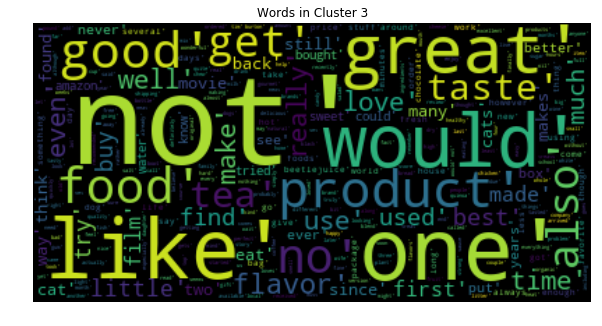

In [52]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd 

stopwords_t = set(STOPWORDS)
wordcloud = WordCloud(background_color="black", max_words=len(str(Clust3)), stopwords=stopwords_t) # , max_font_size=50
wordcloud.generate(str(Clust3))

plt.figure(figsize=(10,10))
plt.title("Words in Cluster 3")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Observation:- 

This word cloud has reviews information related to product, whether it is good or not. It also has information about tea and its taste.

### 5.12 Word Cloud for Cluster 4

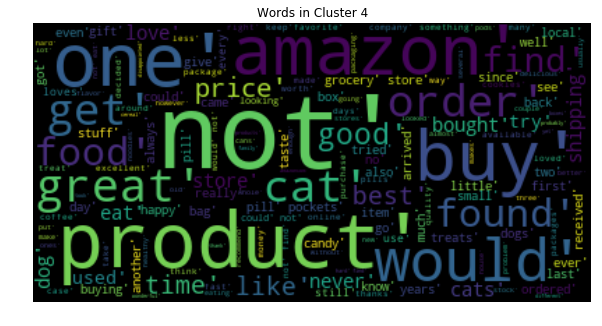

In [86]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd 

stopwords_t = set(STOPWORDS)
wordcloud = WordCloud(background_color="black", max_words=len(str(Clust4)), stopwords=stopwords_t) # , max_font_size=50
wordcloud.generate(str(Clust4))

plt.figure(figsize=(10,10))
plt.title("Words in Cluster 4")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Observation:- 

This word cloud has reviews information related to product, order, buying, price of the product. It also has information about food and cats.

### 5.13 Word Cloud for Cluster 5

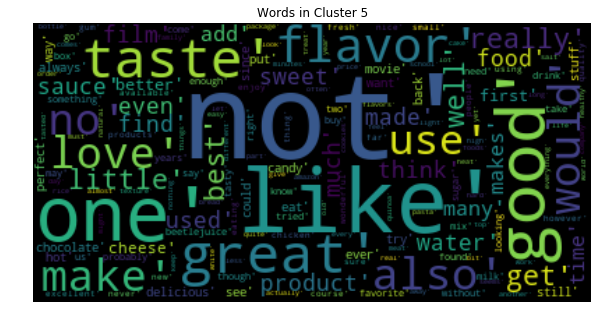

In [87]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd 

stopwords_t = set(STOPWORDS)
wordcloud = WordCloud(background_color="black", max_words=len(str(Clust5)), stopwords=stopwords_t) # , max_font_size=50
wordcloud.generate(str(Clust5))

plt.figure(figsize=(10,10))
plt.title("Words in Cluster 5")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Observation:-

This word cloud has reviews information related to product and it has same information like the previous word clouds.

## 5.14 Agglomerative Clustering on Avg-W2V with 7 Clusters

In [88]:
from sklearn.cluster import AgglomerativeClustering

Agg_clust7 = AgglomerativeClustering(n_clusters=7)
Agg_clust7.fit(sent_vectors_agg)
Agg_clust7

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=7,
            pooling_func=<function mean at 0x000000C2D65D66A8>)

In [89]:
Agg_clust7.labels_.shape[0]

5000

### 5.15 Number of words in each cluster

In [91]:
words_data = words_list
Clust1 = []
Clust2 = []
Clust3 = []
Clust4 = []
Clust5 = []
Clust6 = []
Clust7 = []

for i in range(Agg_clust7.labels_.shape[0]):
    if Agg_clust7.labels_[i] == 0:
        Clust1.append(words_data[i])
    elif Agg_clust7.labels_[i] == 1:
        Clust2.append(words_data[i]) 
    elif Agg_clust7.labels_[i] == 2:
        Clust3.append(words_data[i]) 
    elif Agg_clust7.labels_[i] == 3:
        Clust4.append(words_data[i]) 
    elif Agg_clust7.labels_[i] == 4:
        Clust5.append(words_data[i])
    elif Agg_clust7.labels_[i] == 5:
        Clust6.append(words_data[i])
    else:
        Clust7.append(words_data[i])
                
print("Number of words in Cluster 1 : ",len(Clust1))
print("Number of words in Cluster 2 : ",len(Clust2))
print("Number of words in Cluster 3 : ",len(Clust3))
print("Number of words in Cluster 4 : ",len(Clust4))
print("Number of words in Cluster 5 : ",len(Clust5))
print("Number of words in Cluster 6 : ",len(Clust6))
print("Number of words in Cluster 7 : ",len(Clust7))


Number of words in Cluster 1 :  1856
Number of words in Cluster 2 :  828
Number of words in Cluster 3 :  454
Number of words in Cluster 4 :  465
Number of words in Cluster 5 :  608
Number of words in Cluster 6 :  377
Number of words in Cluster 7 :  412


### 5.16 Word Cloud for Cluster 1

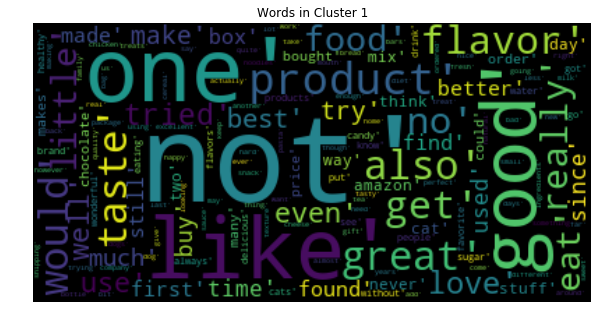

In [104]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd 

stopwords_t = set(STOPWORDS)
wordcloud = WordCloud(background_color="black", max_words=len(str(Clust1)), stopwords=stopwords_t) # , max_font_size=50
wordcloud.generate(str(Clust1))

plt.figure(figsize=(10,10))
plt.title("Words in Cluster 1")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Observation:-

This word cloud has reviews information related to product, whether it is good or not.

### 5.17 Word Cloud for Cluster 2

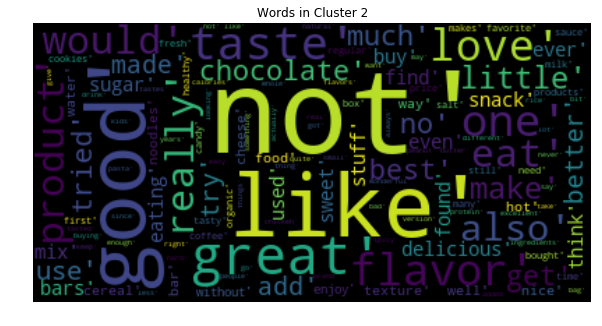

In [105]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd 

stopwords_t = set(STOPWORDS)
wordcloud = WordCloud(background_color="black", max_words=len(str(Clust2)), stopwords=stopwords_t) # , max_font_size=50
wordcloud.generate(str(Clust2))

plt.figure(figsize=(10,10))
plt.title("Words in Cluster 2")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Observation:- 

This word cloud has information about reviews related to chocolate, its flavor and taste.

### 5.18 Word Cloud for Cluster 3

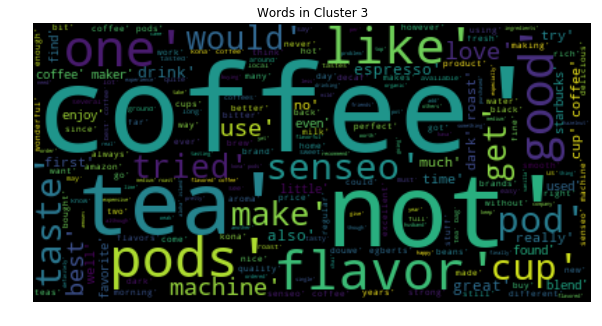

In [106]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd 

stopwords_t = set(STOPWORDS)
wordcloud = WordCloud(background_color="black", max_words=len(str(Clust3)), stopwords=stopwords_t) # , max_font_size=50
wordcloud.generate(str(Clust3))

plt.figure(figsize=(10,10))
plt.title("Words in Cluster 3")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Observation:- 

This word cloud has information about reviews related to coffee, its taste, how it is made. 

### 5.19 Word Cloud for Cluster 4

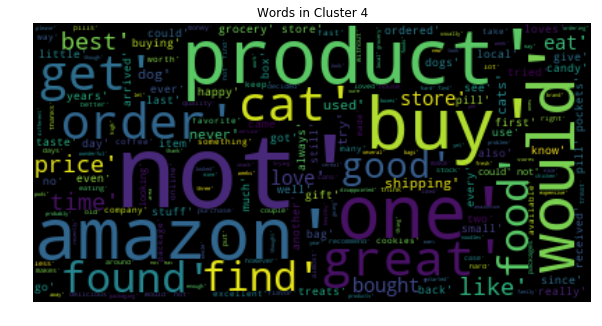

In [107]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd 

stopwords_t = set(STOPWORDS)
wordcloud = WordCloud(background_color="black", max_words=len(str(Clust4)), stopwords=stopwords_t) # , max_font_size=50
wordcloud.generate(str(Clust4))

plt.figure(figsize=(10,10))
plt.title("Words in Cluster 4")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Observation:-  

This word cloud has reviews information related to product, order, buying, price of the product. It also has information about food and cats.

### 5.20 Word Cloud for Cluster 5

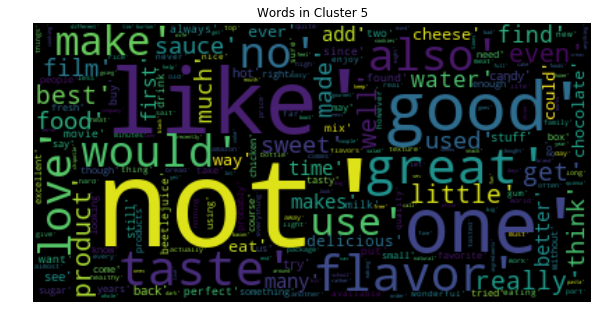

In [108]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd 

stopwords_t = set(STOPWORDS)
wordcloud = WordCloud(background_color="black", max_words=len(str(Clust5)), stopwords=stopwords_t) # , max_font_size=50
wordcloud.generate(str(Clust5))

plt.figure(figsize=(10,10))
plt.title("Words in Cluster 5")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Observation:-  
This word cloud has reviews information related to food, taste, flavor, quantity, film. 


### 5.21 Word Cloud for Cluster 6

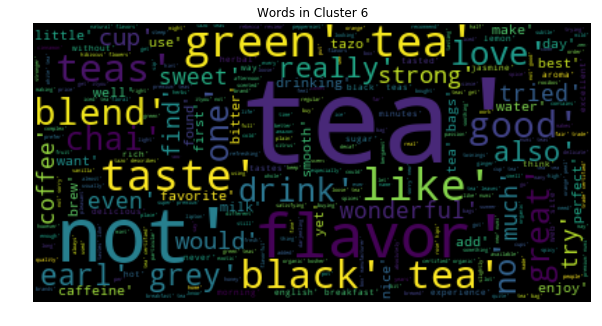

In [109]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd 

stopwords_t = set(STOPWORDS)
wordcloud = WordCloud(background_color="black", max_words=len(str(Clust6)), stopwords=stopwords_t) # , max_font_size=50
wordcloud.generate(str(Clust6))

plt.figure(figsize=(10,10))
plt.title("Words in Cluster 6")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Observation:-  
This word cloud has reviews information related to tea and its different varieties, taste.


### 5.22 Word Cloud for Cluster 7

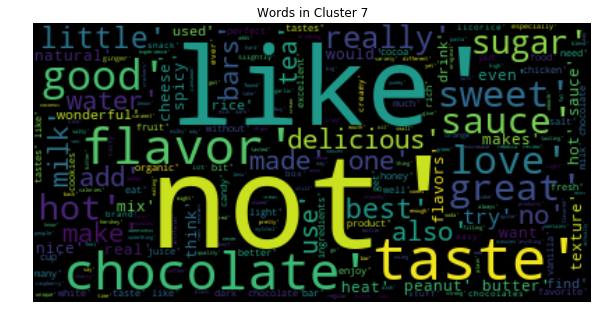

In [110]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd 

stopwords_t = set(STOPWORDS)
wordcloud = WordCloud(background_color="black", max_words=len(str(Clust7)), stopwords=stopwords_t) # , max_font_size=50
wordcloud.generate(str(Clust7))

plt.figure(figsize=(10,10))
plt.title("Words in Cluster 7")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Observation:-

This word cloud has reviews information related to chocolate, taste and flavors.

## 6. TFIDF-W2V

In [112]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

model = TfidfVectorizer()
tfidfw2v_data = model.fit_transform(X1)

# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))


In [113]:
print(tfidfw2v_data.get_shape())

(5000, 22110)


In [115]:
# TF-IDF weighted Word2Vec 

tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_words = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent_agg): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in words_agg:
            try:
                vec = w2v_model.wv[word]
            # tf_idf = tfidf_train_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
                tf_idf = dictionary[word]*(sent.count(word)/len(sent))
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
            except:
                pass
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_words.append(sent_vec)
    row += 1

100%|██████████| 5000/5000 [00:11<00:00, 426.88it/s]


## 6.1 Agglomerative Clustering on TFIDF-W2V with 2 Clusters

In [116]:
from sklearn.cluster import AgglomerativeClustering

Agg_clust2 = AgglomerativeClustering(n_clusters=2)
Agg_clust2.fit(tfidf_words)
Agg_clust2

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=2,
            pooling_func=<function mean at 0x000000C2D65D66A8>)

In [117]:
Agg_clust2.labels_.shape[0]

5000

### 6.2 Number of words in each cluster

In [119]:
words_data = words_list
Clust1 = []
Clust2 = []

for i in range(Agg_clust2.labels_.shape[0]):
    if Agg_clust2.labels_[i] == 0:
        Clust1.append(words_data[i])
    else:
        Clust2.append(words_data[i])
                
print("Number of words in Cluster 1 : ",len(Clust1))
print("Number of words in Cluster 2 : ",len(Clust2))


Number of words in Cluster 1 :  4670
Number of words in Cluster 2 :  330


### 6.3 Word Cloud for Cluster 1

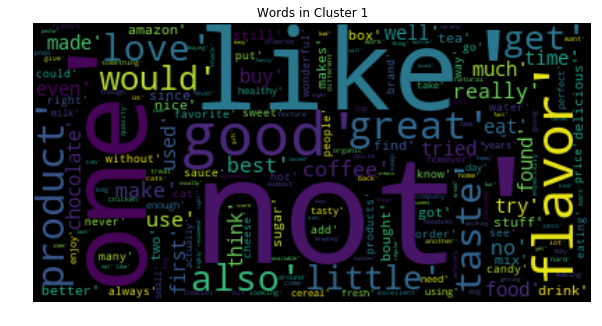

In [124]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd 

stopwords_t = set(STOPWORDS)
wordcloud = WordCloud(background_color="black", max_words=len(str(Clust1)), stopwords=stopwords_t) # , max_font_size=50
wordcloud.generate(str(Clust1))

plt.figure(figsize=(10,10))
plt.title("Words in Cluster 1")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Observation:-

This word cloud has reviews information related to product and whether it is good or not.

### 6.4 Word Cloud for Cluster 2

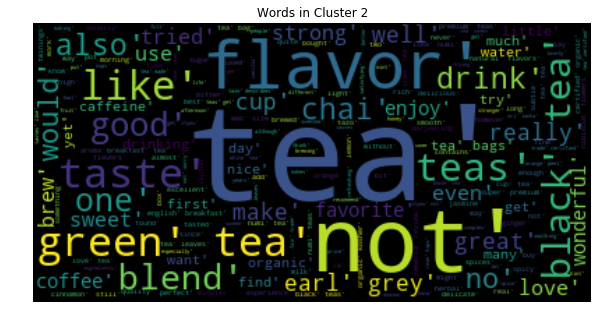

In [125]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd 

stopwords_t = set(STOPWORDS)
wordcloud = WordCloud(background_color="black", max_words=len(str(Clust2)), stopwords=stopwords_t) # , max_font_size=50
wordcloud.generate(str(Clust2))

plt.figure(figsize=(10,10))
plt.title("Words in Cluster 2")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Observation:-

This word cloud has reviews information related to tea and its different varieties, taste.

## 7. Agglomerative Clustering on TFIDF-W2V with 5 Clusters

In [126]:
from sklearn.cluster import AgglomerativeClustering

Agg_clust5_tfidf = AgglomerativeClustering(n_clusters=5)
Agg_clust5_tfidf.fit(tfidf_words)
Agg_clust5_tfidf

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=5,
            pooling_func=<function mean at 0x000000C2D65D66A8>)

In [127]:
Agg_clust5_tfidf.labels_.shape[0]

5000

### 7.1 Number of words in each cluster

In [129]:
words_data = words_list
Clust1 = []
Clust2 = []
Clust3 = []
Clust4 = []
Clust5 = []

for i in range(Agg_clust5_tfidf.labels_.shape[0]):
    if Agg_clust5_tfidf.labels_[i] == 0:
        Clust1.append(words_data[i])
    elif Agg_clust5_tfidf.labels_[i] == 1:
        Clust2.append(words_data[i]) 
    elif Agg_clust5_tfidf.labels_[i] == 2:
        Clust3.append(words_data[i]) 
    elif Agg_clust5_tfidf.labels_[i] == 3:
        Clust4.append(words_data[i]) 
    else:
        Clust5.append(words_data[i])
                
print("Number of words in Cluster 1 : ",len(Clust1))
print("Number of words in Cluster 2 : ",len(Clust2))
print("Number of words in Cluster 3 : ",len(Clust3))
print("Number of words in Cluster 4 : ",len(Clust4))
print("Number of words in Cluster 5 : ",len(Clust5))

Number of words in Cluster 1 :  1939
Number of words in Cluster 2 :  1242
Number of words in Cluster 3 :  1338
Number of words in Cluster 4 :  330
Number of words in Cluster 5 :  151


### 7.2 Word cloud for Cluster 1

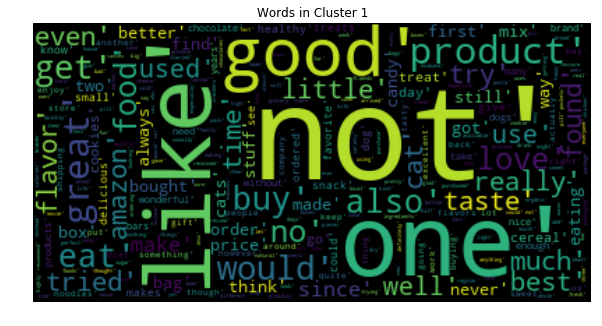

In [137]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd 

stopwords_t = set(STOPWORDS)
wordcloud = WordCloud(background_color="black", max_words=len(str(Clust1)), stopwords=stopwords_t) # , max_font_size=50
wordcloud.generate(str(Clust1))

plt.figure(figsize=(10,10))
plt.title("Words in Cluster 1")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Observation:-

This word cloud describes about reviews related to product, its good or not, food and its flavors, tastes.

### 7.3  Word cloud for Cluster 2

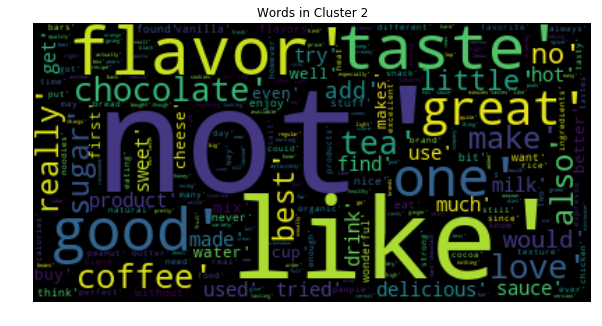

In [138]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd 

stopwords_t = set(STOPWORDS)
wordcloud = WordCloud(background_color="black", max_words=len(str(Clust2)), stopwords=stopwords_t) # , max_font_size=50
wordcloud.generate(str(Clust2))

plt.figure(figsize=(10,10))
plt.title("Words in Cluster 2")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Observation:-

This word cloud describes about reviews related to tea, chocoloate , flavors, taste, quantity.

### 7.4 Word cloud for Cluster 3

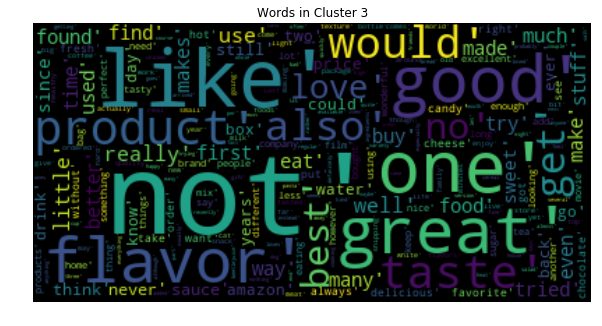

In [139]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd 

stopwords_t = set(STOPWORDS)
wordcloud = WordCloud(background_color="black", max_words=len(str(Clust3)), stopwords=stopwords_t) # , max_font_size=50
wordcloud.generate(str(Clust3))

plt.figure(figsize=(10,10))
plt.title("Words in Cluster 3")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Observation:-

This word cloud describes about reviews related to  product and whether it is good or not.

### 7.5 Word cloud for Cluster 4

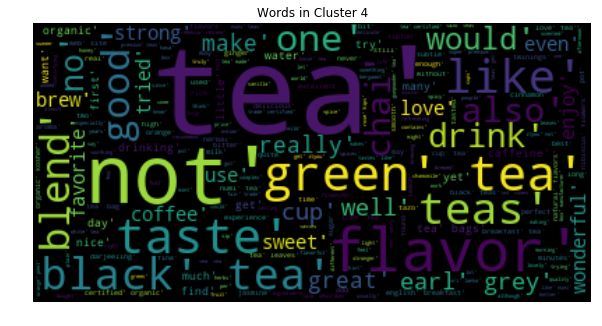

In [140]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd 

stopwords_t = set(STOPWORDS)
wordcloud = WordCloud(background_color="black", max_words=len(str(Clust4)), stopwords=stopwords_t) # , max_font_size=50
wordcloud.generate(str(Clust4))

plt.figure(figsize=(10,10))
plt.title("Words in Cluster 4")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Observation:-

This word cloud same information as previous word clouds like tea and its varieties and taste. 

### 7.6 Word cloud for Cluster 5

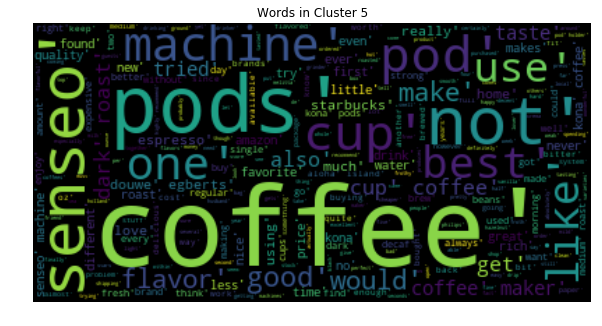

In [141]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd 

stopwords_t = set(STOPWORDS)
wordcloud = WordCloud(background_color="black", max_words=len(str(Clust5)), stopwords=stopwords_t) # , max_font_size=50
wordcloud.generate(str(Clust5))

plt.figure(figsize=(10,10))
plt.title("Words in Cluster 5")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Observation:-

This word cloud describes about reviews related to coffe, machines, cup, flavor and taste.

## 8. Agglomerative Clustering on TFIDF-W2V with 8 Clusters

In [142]:
from sklearn.cluster import AgglomerativeClustering

Agg_clust8_tfidf = AgglomerativeClustering(n_clusters=8)
Agg_clust8_tfidf.fit(tfidf_words)
Agg_clust8_tfidf

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=8,
            pooling_func=<function mean at 0x000000C2D65D66A8>)

In [143]:
Agg_clust8_tfidf.labels_.shape[0]

5000

### 8.1 Words in each cluster

In [145]:
words_data = words_list
Clust1 = []
Clust2 = []
Clust3 = []
Clust4 = []
Clust5 = []
Clust6 = []
Clust7 = []
Clust8 = []

for i in range(Agg_clust8_tfidf.labels_.shape[0]):
    if Agg_clust8_tfidf.labels_[i] == 0:
        Clust1.append(words_data[i])
    elif Agg_clust8_tfidf.labels_[i] == 1:
        Clust2.append(words_data[i]) 
    elif Agg_clust8_tfidf.labels_[i] == 2:
        Clust3.append(words_data[i]) 
    elif Agg_clust8_tfidf.labels_[i] == 3:
        Clust4.append(words_data[i]) 
    elif Agg_clust8_tfidf.labels_[i] == 4:
        Clust5.append(words_data[i])
    elif Agg_clust8_tfidf.labels_[i] == 5:
        Clust6.append(words_data[i])
    elif Agg_clust8_tfidf.labels_[i] == 6:
        Clust7.append(words_data[i])
    else:
        Clust8.append(words_data[i])
                
print("Number of words in Cluster 1 : ",len(Clust1))
print("Number of words in Cluster 2 : ",len(Clust2))
print("Number of words in Cluster 3 : ",len(Clust3))
print("Number of words in Cluster 4 : ",len(Clust4))
print("Number of words in Cluster 5 : ",len(Clust5))
print("Number of words in Cluster 6 : ",len(Clust6))
print("Number of words in Cluster 7 : ",len(Clust7))
print("Number of words in Cluster 8 : ",len(Clust8))


Number of words in Cluster 1 :  330
Number of words in Cluster 2 :  969
Number of words in Cluster 3 :  1338
Number of words in Cluster 4 :  828
Number of words in Cluster 5 :  151
Number of words in Cluster 6 :  765
Number of words in Cluster 7 :  273
Number of words in Cluster 8 :  346


### 8.2 Word cloud for Cluster 1

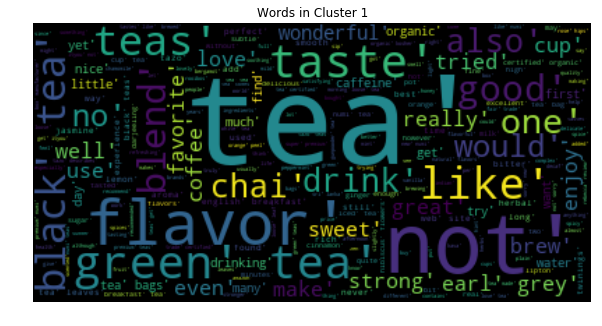

In [147]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd 

stopwords_t = set(STOPWORDS)
wordcloud = WordCloud(background_color="black", max_words=len(str(Clust1)), stopwords=stopwords_t) # , max_font_size=50
wordcloud.generate(str(Clust1))

plt.figure(figsize=(10,10))
plt.title("Words in Cluster 1")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Observation:-

This word cloud describes about reviews related to tea and its taste and different varieties. 

### 8.3 Word cloud for Cluster 2

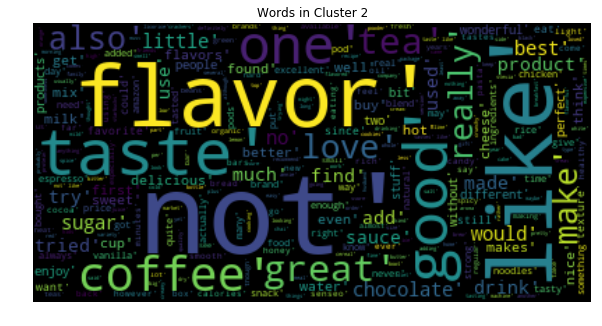

In [149]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd 

stopwords_t = set(STOPWORDS)
wordcloud = WordCloud(background_color="black", max_words=len(str(Clust2)), stopwords=stopwords_t) # , max_font_size=50
wordcloud.generate(str(Clust2))

plt.figure(figsize=(10,10))
plt.title("Words in Cluster 2")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Observation:-

This word cloud has same information as the previous word cloud.

### 8.4 Word cloud for Cluster 3

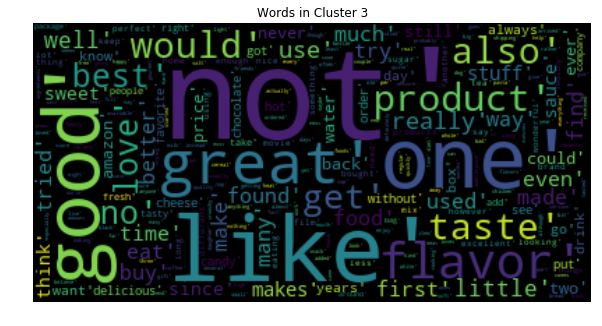

In [150]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd 

stopwords_t = set(STOPWORDS)
wordcloud = WordCloud(background_color="black", max_words=len(str(Clust3)), stopwords=stopwords_t) # , max_font_size=50
wordcloud.generate(str(Clust3))

plt.figure(figsize=(10,10))
plt.title("Words in Cluster 3")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Observation:-

This word cloud describes about reviews related to product, good or not .

### 8.5 Word cloud for Cluster 4

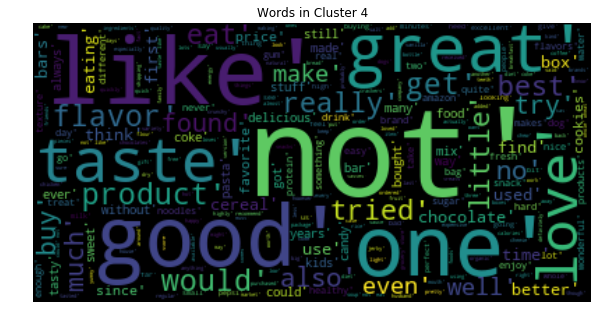

In [151]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd 

stopwords_t = set(STOPWORDS)
wordcloud = WordCloud(background_color="black", max_words=len(str(Clust4)), stopwords=stopwords_t) # , max_font_size=50
wordcloud.generate(str(Clust4))

plt.figure(figsize=(10,10))
plt.title("Words in Cluster 4")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Observation:-

This word cloud also has same information like the previous cloud. 

### 8.6 Word cloud for Cluster 5

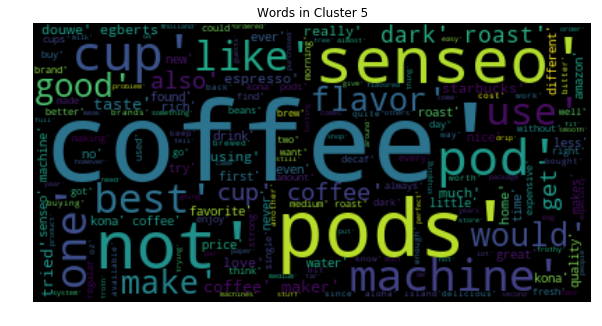

In [152]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd 

stopwords_t = set(STOPWORDS)
wordcloud = WordCloud(background_color="black", max_words=len(str(Clust5)), stopwords=stopwords_t) # , max_font_size=50
wordcloud.generate(str(Clust5))

plt.figure(figsize=(10,10))
plt.title("Words in Cluster 5")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Observation:-

This word cloud describes about reviews related to coffee and its varieties and taste.

### 8.7 Word cloud for Cluster 6

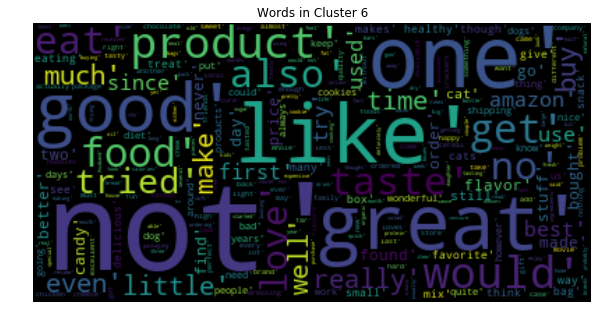

In [153]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd 

stopwords_t = set(STOPWORDS)
wordcloud = WordCloud(background_color="black", max_words=len(str(Clust6)), stopwords=stopwords_t) # , max_font_size=50
wordcloud.generate(str(Clust6))

plt.figure(figsize=(10,10))
plt.title("Words in Cluster 6")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Observation:-

This word cloud describes about reviews related to product, good or not, quantity.

### 8.8 Word cloud for Cluster  7

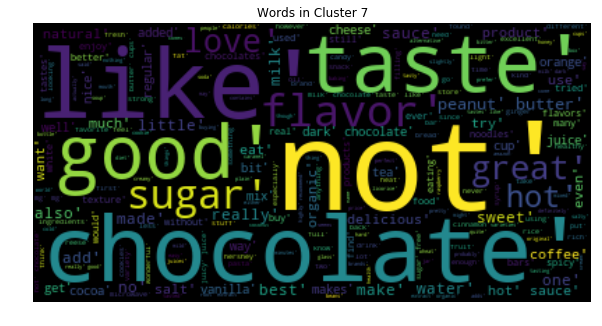

In [154]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd 

stopwords_t = set(STOPWORDS)
wordcloud = WordCloud(background_color="black", max_words=len(str(Clust7)), stopwords=stopwords_t) # , max_font_size=50
wordcloud.generate(str(Clust7))

plt.figure(figsize=(10,10))
plt.title("Words in Cluster 7")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Observation:-

It has information about chocolate, sugar and its taste and flavor.

### 8.9 Word cloud for Cluster 8

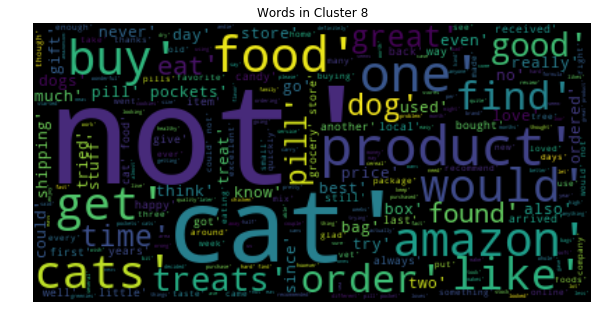

In [155]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd 

stopwords_t = set(STOPWORDS)
wordcloud = WordCloud(background_color="black", max_words=len(str(Clust8)), stopwords=stopwords_t) # , max_font_size=50
wordcloud.generate(str(Clust8))

plt.figure(figsize=(10,10))
plt.title("Words in Cluster 8")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Observation:-

This word cloud has information about product, cats, dog, where can we buy those, amazon orders, food and its taste.

# DBSCAN Clustering

Centroid-based algorithm = K-means clustering
Hierarchical based algorithm = Agglomerative clustering

Now the density based = DBSCAN which is a popular algorithm

##### DBSCAN - Density Based spatial Clustering of applications with noise:-
1. In this algorithm, the total dataset is divided into dense and sparse regions, where dense regions contains clusters and sparse regions have noise. 
2. Dense regions are seperated by sparse region which is a noise data.
3. So to measure the density we have different methods like Min points, Epsilon, core point, border point, noise point.

###### Min points and Epsilon:-
1. These are the hyperparameters of DBSCAN.
2. density at a point P:- The number of points within a hypersphere of radius Epsilon aroung P
3. dense region:- A hypersphere/circle of radius Epsilon that contains atleast Min points.If the region has points more than Min points then it is called dense region. If it has less points than the Min points then that region is called sparse region.
4. So Min points says, that the minimum number of points that we should have within an epsilon radius for a region to be called dense region.

###### Core point:- 
A point P is said to be core point if P has points >= min points in an epsilon radius around it. Core point always belongs to dense region.
###### Border point:-
A point P is said to be Border point if P is not a core point, if P has points < Min points in epsilon radius around it and P belongs to the neighbourhood of other point Q which is a core point, where dist(P, Q) <= Eps.

###### Noise point:-
Any point which is neither core point nor a border point is a noise point.

###### Density edge and Density connected points:-

1. density edge means connection. If 2 points P and Q are 1) core points and 2) dist(P,Q) <= Eps , then the edge which connects P and Q is called Density edge. So for a edge to be a density edge, it should satisfy the 2 above conditions.

2. density connected points:- 2 points P and Q which are core points and there is a path which is formed by density edges and connection P and Q, then these points P and Q are said to be density connected points.

So DBSCAN is noise resistant and robust algorithm.

##### DBSCAN Algorithm:-
1. Given the 2 hyper parameters Min points and Epsilon, we have to label every point in a dataset as a core point or border point or noise point.

To label the points we need to computer rangeQuery which returns all the points which are in epsilon radius. rangeQuery is used in kd-tree.

2. Remove all noise points from data as they belong to sparse regions and they don't belong to any clusters.
3. For each core point P that is not assigned to a cluster, then
   a) create a new cluster with P
   b) add all points that are density connected to P into this cluster. To find density connected we have to do rangeQuery(Xi, D, eps) or regionQuery which gives all the points within the epsilon distance.

repeat step 3 until all points become clustered.

4. Take each border point and assign it to the nearest core points cluster.

5. Min points helps to remove noise and Min points is always less than equal to dimensionality. This is rule of thumb.
6. We will have larger value of Min points if dataset is more noisy, to remove noisy points we choose larger value of Min points.
7. Min points can be defined by domain expert. These are the 3 ways to select Min points.
8. Epsilon can be determined using knee/elbow method.

DBSCAN can handle clusters of different sizes and shapes.

DBSCAN fails when there is a small change in the epsilon value, we get completely different clusters. It is extremely sensitive to hyperparameters.

It also fails when we have data of different densities. It also doesn't work well when we have high dimensional data like text data. So we don't apply DBSCAN for high dimension data.

## 9. DBSCAN Clustering on Word2Vec

In [41]:
i=0
list_of_sent_dbscan=[]
for sent in X1:
    list_of_sent_dbscan.append(sent.split())

In [42]:
# One sentence is converted into a list
print(X1.values[1])
print("*****************************************************************")
print(list_of_sent_dbscan[1])

remember seeing show aired television years ago child sister later bought lp day thirty somethingi used series books songs student teaching preschoolers turned whole school purchasing cd along books children tradition lives
*****************************************************************
['remember', 'seeing', 'show', 'aired', 'television', 'years', 'ago', 'child', 'sister', 'later', 'bought', 'lp', 'day', 'thirty', 'somethingi', 'used', 'series', 'books', 'songs', 'student', 'teaching', 'preschoolers', 'turned', 'whole', 'school', 'purchasing', 'cd', 'along', 'books', 'children', 'tradition', 'lives']


In [43]:
from gensim.models import Word2Vec
w2v_model = Word2Vec(list_of_sent_dbscan, min_count=5, size=50, workers=4)

#words = w2v_model[w2v_model.wv.vocab]
# we can get dictionary of all the words that we have
# we are storing Word2Vec model in w2v_model
words_dbscan = list(w2v_model.wv.vocab)
print(len(words_dbscan))

# prints 50 words
print("sample words ", words_dbscan[0:50])

4976
sample words  ['little', 'book', 'makes', 'son', 'laugh', 'loud', 'car', 'driving', 'along', 'always', 'sing', 'learned', 'india', 'roses', 'love', 'new', 'words', 'classic', 'willing', 'bet', 'still', 'able', 'memory', 'college', 'remember', 'seeing', 'show', 'television', 'years', 'ago', 'child', 'sister', 'later', 'bought', 'day', 'thirty', 'used', 'series', 'books', 'songs', 'student', 'turned', 'whole', 'school', 'purchasing', 'cd', 'children', 'tradition', 'lives', 'beetlejuice']


## 9.1 AVG-W2V

In [45]:
# average Word2Vec 
# compute average word2vec for each review.
from tqdm import tqdm
#List to store all the avg w2vec's 
sent_vectors_dbscan = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent_dbscan): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # to count num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in words_dbscan:
            vec = w2v_model.wv[word] # vector of each word using w2v model
            sent_vec += vec # Adding the vectors
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words  # Taking average of vectors sum of the particular review
    sent_vectors_dbscan.append(sent_vec)  # Storing the avg w2vec's for each review in the list
print(len(sent_vectors_dbscan))
print(len(sent_vectors_dbscan[0]))

100%|██████████| 5000/5000 [00:09<00:00, 512.59it/s]


5000
50


### 9.2 Standardising the W2V data

In [46]:
from sklearn.preprocessing import StandardScaler

w2v_data = StandardScaler().fit_transform(sent_vectors_dbscan)

In [47]:
w2v_data.shape[0]

5000

#### Finding min_points

In [48]:
min_points = 2 * w2v_data.shape[1]
min_points

100

### 9.3 Computing distances of nth-nearest neighbours to min_points

In [49]:
# Reference - https://stackoverflow.com/questions/48010276/how-to-estimate-eps-using-knn-distance-plot-in-dbscan
from sklearn.neighbors import NearestNeighbors
min_points = 100
neighbors = NearestNeighbors(n_neighbors = min_points)
neighbors.fit(w2v_data)

# distances is the distance from point Xi to the min_points value(100) nearest neighbors of Xi. 
# or distances is the distance  of n-nearest neighbors from point Xi within the limit of min_points value(100) 
distances, index = neighbors.kneighbors(w2v_data)
sorted_dist = sorted(distances[:, min_points-1])
points = list(range(1,len(w2v_data)+1))


### 9.4 Plotting Distances vs Points plot

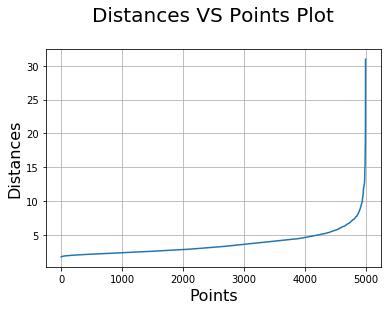

In [50]:
# Plot distances(di from Xi) VS points(which are Xi's) plot
plt.plot(points, sorted_dist)
plt.xlabel('Points',size=16)
plt.ylabel('Distances',size=16)
plt.title('Distances VS Points Plot\n',size=20)
plt.grid()
plt.show()

#### Observation:- 

1. From the above plot, we can find the optimal value for epsilon is 7 . This point 7 is like a elbow point. After this value 7 , there is sharp rise in the curve.
2. Above method is called elbow-knee method

## 9.5 DBSCAN for AvgW2V

In [51]:
from sklearn.cluster import DBSCAN
min_points = 100 
epsilon = 7
db_w2v = DBSCAN(eps = epsilon, min_samples = min_points, n_jobs=-1)
db_w2v.fit(w2v_data)
db_w2v

DBSCAN(algorithm='auto', eps=7, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=100, n_jobs=-1, p=None)

In [52]:
db_w2v.labels_.shape[0]

5000

In [55]:
labels = db_w2v.labels_
labels

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0

### 9.6 Finding Number of Noise points which are labeled as -1

In [56]:
# reference - https://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html#sphx-glr-auto-examples-cluster-plot-dbscan-py

n_noise_ = list(labels).count(-1)
print('Number of noise points: %d' % n_noise_)

Number of noise points: 36


### 9.7 Removing noise points and printing number of remaining points

In [57]:
# Removing noise points and printing number of non-noise points.

new_labels = []
for i in range(len(labels)):
    if labels[i] == 0:
        new_labels.append(i)  # if label = 0 then append it to new_labels list, otherwise discard the point
print(len(new_labels))

4964


### 9.8 Number of Clusters

In [58]:
# Finding number of clusters by eliminating noise points labeled as -1

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print('Number of clusters: %d' % n_clusters_)

Number of clusters: 1


### 9.9 Number of Words in Cluster

In [59]:
# printing Number of Words in Cluster
Cluster = []
for i in range(len(new_labels)):
    Cluster.append(words_list[new_labels[i]])
print("Number of words in Cluster : ",len(Cluster))

Number of words in Cluster :  4964


### 9.10 Word Cloud for Cluster

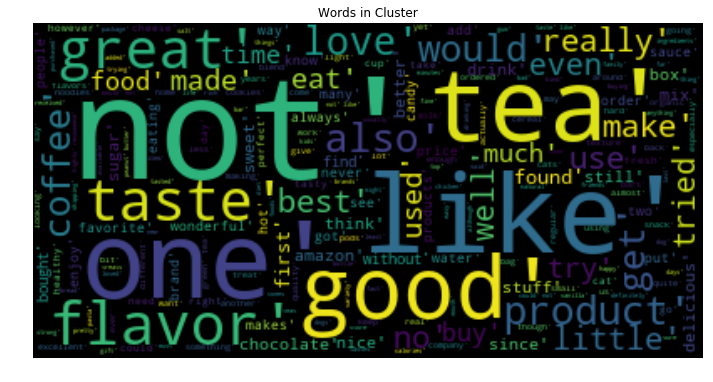

In [60]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd 
stopwords_t = set(STOPWORDS)
wordcloud = WordCloud(background_color="black", max_words=len(str(Cluster)), stopwords=stopwords_t) # , max_font_size=50
wordcloud.generate(str(Cluster))

plt.figure(figsize=(12,12))
plt.title("Words in Cluster")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


#### Observation:-

This word cloud has reviews information related to food, flavor and taste. It also says about products whether it is good or not.

## 10. DBSCAN Clustering on TFIDF-W2V

In [61]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

model = TfidfVectorizer()
tfidfw2v_data = model.fit_transform(X1)

# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))


In [62]:
print(tfidfw2v_data.get_shape())

(5000, 22110)


In [63]:
# TF-IDF weighted Word2Vec 

tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_words = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent_dbscan): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in words_dbscan:
            try:
                vec = w2v_model.wv[word]
            # tf_idf = tfidf_train_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
                tf_idf = dictionary[word]*(sent.count(word)/len(sent))
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
            except:
                pass
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_words.append(sent_vec)
    row += 1

100%|██████████| 5000/5000 [00:12<00:00, 398.07it/s]


### 10.1 Standardising the TFIDF-W2V data

In [64]:
from sklearn.preprocessing import StandardScaler

tfidfw2v_data = StandardScaler().fit_transform(tfidf_words)

In [65]:
tfidfw2v_data.shape[0]

5000

### 10.2 Finding min_points

In [66]:
min_points = 2 * tfidfw2v_data.shape[1]
min_points

100

### 10.3 Computing distances of nth-nearest neighbours to min_points

In [69]:
# Reference - https://stackoverflow.com/questions/48010276/how-to-estimate-eps-using-knn-distance-plot-in-dbscan
from sklearn.neighbors import NearestNeighbors
min_points = 100
neighbors = NearestNeighbors(n_neighbors = min_points)
neighbors.fit(tfidfw2v_data)

# distances is the distance from point Xi to the min_points value(100) nearest neighbors of Xi. 
# or distances is the distance  of n-nearest neighbors from point Xi within the limit of min_points value(100) 
distances, index = neighbors.kneighbors(tfidfw2v_data)
sorted_dist = sorted(distances[:, min_points-1])
points = list(range(1,len(tfidfw2v_data)+1))


### 10.4 Plotting Distances vs Points plot

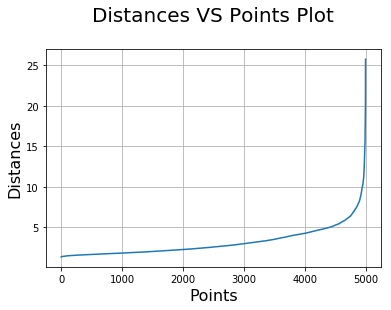

In [70]:
# Plot distances(di from Xi) VS points(which are Xi's) plot
plt.plot(points, sorted_dist)
plt.xlabel('Points',size=16)
plt.ylabel('Distances',size=16)
plt.title('Distances VS Points Plot\n',size=20)
plt.grid()
plt.show()

#### Observation:- 

1. From the above plot, we can find the optimal value for epsilon is 6 . This point 6 is like a elbow point. After this value 7 , there is sharp rise in the curve.
2. Above method is called elbow-knee method

## 10.5 DBSCAN for TFIDF-W2V

In [71]:
from sklearn.cluster import DBSCAN
min_points = 100 
epsilon = 6
db_tfidfw2v = DBSCAN(eps = epsilon, min_samples = min_points, n_jobs=-1)
db_tfidfw2v.fit(tfidfw2v_data)
db_tfidfw2v

DBSCAN(algorithm='auto', eps=6, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=100, n_jobs=-1, p=None)

In [72]:
db_tfidfw2v.labels_.shape[0]

5000

In [74]:
labels = db_tfidfw2v.labels_
labels

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,
        0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,
        0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0

### 10.6 Finding Number of Noise points which are labeled as -1

In [75]:
# reference - https://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html#sphx-glr-auto-examples-cluster-plot-dbscan-py

n_noise_ = list(labels).count(-1)
print('Number of noise points: %d' % n_noise_)

Number of noise points: 58


### 10.7 Removing noise points and printing number of remaining points

In [76]:
# Removing noise points and printing number of non-noise points.

new_labels = []
for i in range(len(labels)):
    if labels[i] == 0:
        new_labels.append(i)  # if label = 0 then append it to new_labels list, otherwise discard the point
print(len(new_labels))

4942


### 10.8 Number of Clusters

In [77]:
# Finding number of clusters by eliminating noise points labeled as -1

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print('Number of clusters: %d' % n_clusters_)

Number of clusters: 1


### 10.9 Number of Words in Cluster

In [79]:
# printing Number of Words in Cluster
Cluster = []
for i in range(len(new_labels)):
    Cluster.append(words_list[new_labels[i]])
print("Number of words in Cluster : ",len(Cluster))

Number of words in Cluster :  4942


### 10.10 Word Cloud for Cluster

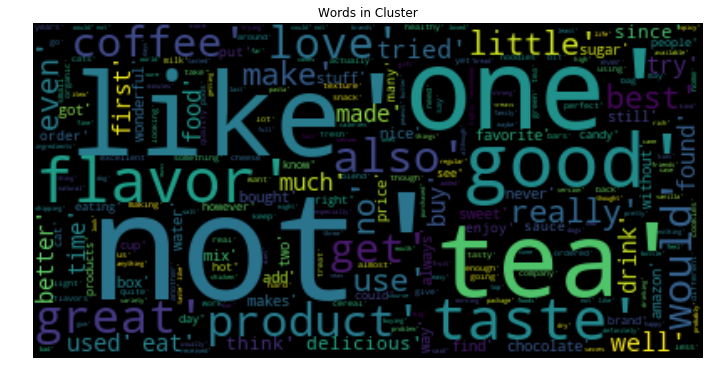

In [80]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd 
stopwords_t = set(STOPWORDS)
wordcloud = WordCloud(background_color="black", max_words=len(str(Cluster)), stopwords=stopwords_t) # , max_font_size=50
wordcloud.generate(str(Cluster))

plt.figure(figsize=(12,12))
plt.title("Words in Cluster")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


#### Observation:-

This word cloud has reviews information related to  tea, coffee , its taste and flavor, about product.

## 11. Models Summarization

In [89]:
from pandas import DataFrame
Clustering = {'Vectorizer':['AVG-W2V', 'TFIDF-W2V'], 'Model1':['Agglomerative clustering','Agglomerative clustering'],
              'Number of clusters for Agglomerative Clustering':['2, 5, 7','2, 5, 8'],
               'Model2':['DBSCAN Clustering','DBSCAN Clustering'],
               'min_points':['100','100'],'epsilon':['7','6']}

In [90]:
Final_conclusions = DataFrame(Clustering)
Final_conclusions

Vectorizer                    Model1  \
0    AVG-W2V  Agglomerative clustering   
1  TFIDF-W2V  Agglomerative clustering   

  Number of clusters for Agglomerative Clustering             Model2  \
0                                         2, 5, 7  DBSCAN Clustering   
1                                         2, 5, 8  DBSCAN Clustering   

  min_points epsilon  
0        100       7  
1        100       6

## 12. Conclusions:-

1. From the above observations we can see that ,in DBSCAN clustering both featurizations AvgW2V and TFIDF-W2V have same min_points value as 100.
2. For AvgW2V epsilon value if 7 and for TFIDF-W2V epislon value is 6.